In [1]:
import os
import sys
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
sys.path.append("./npy")
import utilities as util

In [2]:
num_samples = 1000
fs = 204800  # frequenza di campionamento in Hz
filename = "Channel55.csv"
file_path = os.path.join("../../timeseries/B101/", filename)
df = util.load_dataframe(file_path)
ts = df['singleData'].iloc[:num_samples].to_numpy()
N = len(ts)

In [3]:
# Calcola FFT
yf = np.abs(fft(ts))
xf = fftfreq(N, 1/fs)

# Considera solo la parte positiva dello spettro
xf_pos = xf[:N//2]
yf_pos = yf[:N//2]

# Trova i picchi principali nello spettro
picchi, _ = find_peaks(yf_pos, height=np.max(yf_pos)*0.20)  # threshold al 20% del massimo
frequenze_dominanti = xf_pos[picchi]

In [4]:
# Stampa le prime frequenze dominanti
print("Frequenze dominanti (Hz):", frequenze_dominanti[:10])

# Calcola e stampa il periodo della frequenza dominante
if len(frequenze_dominanti) > 0:
    freq_principale = frequenze_dominanti[0]
    periodo = 1 / freq_principale
    print(f"Frequenza principale: {freq_principale:.2f} Hz")
    print(f"Periodo corrispondente: {periodo*1e3:.3f} ms")
else:
    print("Nessun picco dominante rilevato.")

Frequenze dominanti (Hz): [ 614.4 1433.6 2048.  2457.6 3072.  3481.6 4300.8 4710.4 5529.6 5939.2]
Frequenza principale: 614.40 Hz
Periodo corrispondente: 1.628 ms


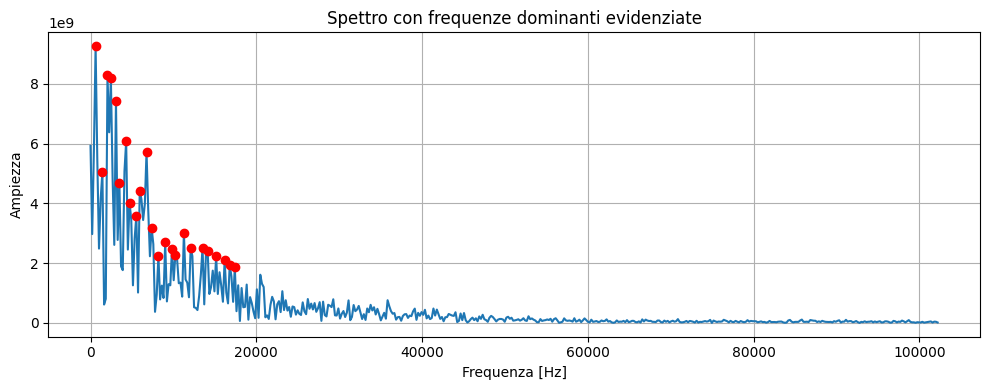

In [5]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(xf_pos, yf_pos)
plt.plot(frequenze_dominanti, yf_pos[picchi], "ro")
plt.title("Spettro con frequenze dominanti evidenziate")
plt.xlabel("Frequenza [Hz]")
plt.ylabel("Ampiezza")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# filtro passa-basso
def filtro_passabanda(signal, fs, f_center, bandwidth):
    f_low = f_center - bandwidth / 2
    f_high = f_center + bandwidth / 2
    b, a = butter(N=4, Wn=[f_low, f_high], btype='bandpass', fs=fs)
    segnale_filtrato = filtfilt(b, a, signal)
    return segnale_filtrato

In [ ]:
def filtro_passa_basso(signal, fs, cutoff=20000, order=2):
    # Normalizza la frequenza di taglio rispetto alla Nyquist
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq

    # Crea i coefficienti del filtro Butterworth
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Applica il filtro in modo non causale per evitare sfasamenti
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

In [8]:
def wavelet_lowpass(signal, fs, cutoff_hz, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calcola la frequenza per ciascun livello
    freqs = [(fs / 2**(j+1), fs / 2**j) for j in range(1, level+1)]

    # Annulla i livelli con frequenze superiori alla cutoff
    for i, (low, high) in enumerate(freqs):
        if low >= cutoff_hz:
            coeffs[i+1] = np.zeros_like(coeffs[i+1])  # D(i+1)

    # Ricostruzione del segnale filtrato
    filtered_signal = pywt.waverec(coeffs, wavelet)
    return filtered_signal

In [14]:
# applichiamo filtro passa basso data una soglia di frequenza
fs = 204800             # Frequenza di campionamento (Hz)
cutoff = 25000          # Frequenza di taglio (Hz)
order = 6

# Design filtro
b, a = butter(order, cutoff / (0.5 * fs), btype='low')
# filtered_signal = filtfilt(b, a, ts)
filtered_signal = filtro_passa_basso(ts, fs)

In [ ]:
# applichiamo filtro passabanda rispetto alla frequenza dominante
f0 = 613.5  # frequenza centrale trovata (in Hz)
bandwidth = 100  # larghezza di banda del filtro

# --- Applica filtro ---
filtered_signal = filtro_passabanda(ts, fs, f0, bandwidth)

In [10]:
fs = 204800             # Frequenza di campionamento (Hz)
cutoff_hz = 30000       # Frequenza di cutoff

filtered_signal = wavelet_lowpass(ts, fs, cutoff_hz, wavelet='db4', level=4)

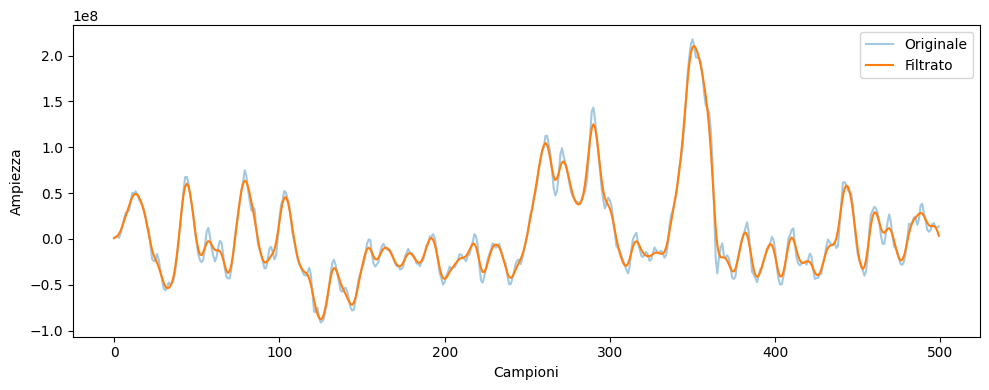

In [15]:
# --- Plot confronto segnale originale e filtrato ---
plt.figure(figsize=(10, 4))
plt.plot(ts[:500], alpha=0.4, label='Originale')
plt.plot(filtered_signal[:500], label='Filtrato')
plt.xlabel("Campioni")
plt.ylabel("Ampiezza")
plt.legend()
plt.tight_layout()
plt.show()